In [ ]:
#get two different cluster outputs

In [1]:
import pickle
import pandas as pd
import time
import os
from collections import Counter
import numpy as np
from sklearn.cluster import KMeans
import hdbscan 

BASE_OUTPUT_DIR = 'data/4-2/HDBSCAN/' 

ALGORITHM = 'hdbscan' 

INPUT_VECTORS_PATH = 'data/4-1/PCA/reduced_vectors_pca_128d.npy'

INPUT_ORIGINAL_TEXT_PATH = 'data/paragraph.pkl'

K_MEANS_N_CLUSTERS = 30000 
HDBSCAN_MIN_CLUSTER_SIZE = 5 
HDBSCAN_MIN_SAMPLES = 1      

input_vector_name = os.path.basename(INPUT_VECTORS_PATH).replace('.npy', '')
experiment_name = f'{ALGORITHM.upper()}_on_{input_vector_name}'
OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, experiment_name)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_CLUSTERS_CSV_PATH = os.path.join(OUTPUT_DIR, 'document_clusters.csv')
OUTPUT_MERGED_DOCS_PATH = os.path.join(OUTPUT_DIR, 'merged_documents.pkl')


def run_kmeans_clustering(vectors, n_clusters):
    print("\n--- 正在执行 K-Means 聚类 ---")
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto', algorithm='lloyd')
    labels = kmeans.fit_predict(vectors)
    
    print(f"K-Means 聚类完成，耗时: {time.time() - start_time:.2f} 秒")
    
    clusters = [[] for _ in range(n_clusters)]
    for doc_index, cluster_label in enumerate(labels):
        clusters[cluster_label].append(doc_index)
        
    outliers = []
    
    return {'clusters': clusters, 'outliers': outliers}

def run_hdbscan_clustering(vectors, min_cluster_size, min_samples):
    print("\n--- 正在执行 HDBSCAN 聚类 ---")
    start_time = time.time()
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        core_dist_n_jobs=14
    )
    labels = clusterer.fit_predict(vectors)
    
    print(f"HDBSCAN 聚类完成，耗时: {time.time() - start_time:.2f} 秒")
    
    n_clusters = labels.max() + 1
    clusters = [[] for _ in range(n_clusters)]
    outliers = []
    for doc_index, cluster_label in enumerate(labels):
        if cluster_label == -1:
            outliers.append(doc_index)
        else:
            clusters[cluster_label].append(doc_index)
            
    return {'clusters': clusters, 'outliers': outliers}

def run_ablation_study():
    print(f"========== 正在使用 [{ALGORITHM.upper()}] 算法进行处理 ==========")
    print(f"--- 输入向量: {INPUT_VECTORS_PATH} ---")
    print(f"--- 所有输出将被保存到: {OUTPUT_DIR} ---") 
    
    if not os.path.exists(INPUT_VECTORS_PATH):
        raise FileNotFoundError(f"向量文件未找到: {INPUT_VECTORS_PATH}")
    vectors = np.load(INPUT_VECTORS_PATH).astype(np.float32)

    if ALGORITHM == 'kmeans':
        clustering_results = run_kmeans_clustering(vectors, K_MEANS_N_CLUSTERS)
    elif ALGORITHM == 'hdbscan':
        clustering_results = run_hdbscan_clustering(vectors, HDBSCAN_MIN_CLUSTER_SIZE, HDBSCAN_MIN_SAMPLES)
    else:
        raise ValueError(f"未知的算法: {ALGORITHM}. 请选择 'kmeans' 或 'hdbscan'.")

    clusters = clustering_results.get('clusters', [])
    outliers = clustering_results.get('outliers', [])
    
    print(f"\n--- 正在从 {INPUT_ORIGINAL_TEXT_PATH} 加载原始文本... ---")
    if not os.path.exists(INPUT_ORIGINAL_TEXT_PATH):
        raise FileNotFoundError(f"原始文本文件未找到: {INPUT_ORIGINAL_TEXT_PATH}")
    with open(INPUT_ORIGINAL_TEXT_PATH, 'rb') as f:
        paragraph = pickle.load(f)
        
    n_total_docs = len(paragraph)
    
    print(f"\n--- [{ALGORITHM.upper()}] 聚类结果分析 ---")
    n_clusters = len(clusters)
    n_outliers = len(outliers)
    num_clustered_docs = sum(len(c) for c in clusters)
    
    print(f"从 {n_total_docs} 篇文档中，识别出:")
    print(f"   - {n_clusters} 个簇，共包含 {num_clustered_docs} 篇文档。")
    print(f"   - {n_outliers} 个离群点 (将被作为独立文档保留)。")
    
    if n_clusters > 0:
        avg_docs_per_cluster = num_clustered_docs / n_clusters
        print(f"   - 平均每个簇由 {avg_docs_per_cluster:.2f} 篇原始文档构成。")

    print("\n--- 正在构建每篇文档的聚类标签... ---")
    labels = [-1] * n_total_docs
    for cluster_id, doc_indices in enumerate(clusters):
        for doc_index in doc_indices:
            if 0 <= doc_index < n_total_docs:
                labels[doc_index] = cluster_id
            
    documents_text = [" ".join(text) if isinstance(text, list) else "" for text in paragraph]
    results_df = pd.DataFrame({
        'document_index': range(n_total_docs),
        'document_text': documents_text,
        'cluster_label': labels
    })
    results_df.sort_values(by='cluster_label', inplace=True)
    results_df.to_csv(OUTPUT_CLUSTERS_CSV_PATH, index=False, encoding='utf-8-sig')
    print(f"详细结果已保存到: {OUTPUT_CLUSTERS_CSV_PATH}")

    print("\n--- 正在合并文档... ---")
    merged_docs_list = []
    
    for doc_indices in clusters:
        merged_doc = []
        for doc_index in doc_indices:
            if 0 <= doc_index < len(paragraph):
                merged_doc.extend(paragraph[doc_index])
        if merged_doc:
            merged_docs_list.append(merged_doc)

    for outlier_index in outliers:
        if 0 <= outlier_index < len(paragraph):
            merged_docs_list.append(paragraph[outlier_index])
            
    final_doc_count = len(merged_docs_list)
    print(f"--- 共生成 {final_doc_count} 篇新文档 (由 {n_clusters} 个超级文档 和 {n_outliers} 个独立文档组成)。 ---")

    with open(OUTPUT_MERGED_DOCS_PATH, 'wb') as f:
        pickle.dump(merged_docs_list, f)
        
    print(f"成功将合并后的文档保存到: {OUTPUT_MERGED_DOCS_PATH}")

if __name__ == '__main__':
    run_ablation_study()

========== 正在使用 [HDBSCAN] 算法进行处理 ==========
--- 输入向量: data/4-1/PCA/reduced_vectors_pca_128d.npy ---
--- 所有输出将被保存到: data/4-2/HDBSCAN/HDBSCAN_on_reduced_vectors_pca_128d ---

--- 正在执行 HDBSCAN 聚类 ---
HDBSCAN 聚类完成，耗时: 8712.77 秒

--- 正在从 data/paragraph.pkl 加载原始文本... ---

--- [HDBSCAN] 聚类结果分析 ---
从 274378 篇文档中，识别出:
   - 8795 个簇，共包含 89816 篇文档。
   - 184562 个离群点 (将被作为独立文档保留)。
   - 平均每个簇由 10.21 篇原始文档构成。

--- 正在构建每篇文档的聚类标签... ---
详细结果已保存到: data/4-2/HDBSCAN/HDBSCAN_on_reduced_vectors_pca_128d\document_clusters.csv

--- 正在合并文档... ---
--- 共生成 193357 篇新文档 (由 8795 个超级文档 和 184562 个独立文档组成)。 ---
成功将合并后的文档保存到: data/4-2/HDBSCAN/HDBSCAN_on_reduced_vectors_pca_128d\merged_documents.pkl


In [13]:
import pickle
import pandas as pd
import time
import os
from collections import Counter
import numpy as np
from sklearn.cluster import KMeans
import hdbscan 

BASE_OUTPUT_DIR = 'data/4-2/k-means/' 
ALGORITHM = 'kmeans' 
INPUT_VECTORS_PATH = 'data/4-1/PCA/reduced_vectors_pca_128d_norm.npy'
INPUT_ORIGINAL_TEXT_PATH = 'data/paragraph.pkl'


K_MEANS_N_CLUSTERS = 30000 
HDBSCAN_MIN_CLUSTER_SIZE = 5 
HDBSCAN_MIN_SAMPLES = 1      

input_vector_name = os.path.basename(INPUT_VECTORS_PATH).replace('.npy', '')
experiment_name = f'{ALGORITHM.upper()}_on_{input_vector_name}'
OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, experiment_name)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_CLUSTERS_CSV_PATH = os.path.join(OUTPUT_DIR, 'document_clusters.csv')
OUTPUT_MERGED_DOCS_PATH = os.path.join(OUTPUT_DIR, 'merged_documents.pkl')


def run_kmeans_clustering(vectors, n_clusters):
    print("\n--- 正在执行 K-Means 聚类 ---")
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, algorithm='lloyd')
    
    labels = kmeans.fit_predict(vectors)
    
    print(f"K-Means 聚类完成，耗时: {time.time() - start_time:.2f} 秒")

    clusters = [[] for _ in range(n_clusters)]
    for doc_index, cluster_label in enumerate(labels):
        clusters[cluster_label].append(doc_index)
        
    outliers = []
    
    return {'clusters': clusters, 'outliers': outliers}

def run_hdbscan_clustering(vectors, min_cluster_size, min_samples):
    print("\n--- 正在执行 HDBSCAN 聚类 ---")
    start_time = time.time()
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        core_dist_n_jobs=-1
    )
    labels = clusterer.fit_predict(vectors)
    
    print(f"HDBSCAN 聚类完成，耗时: {time.time() - start_time:.2f} 秒")
    
    n_clusters = labels.max() + 1
    clusters = [[] for _ in range(n_clusters)]
    outliers = []
    for doc_index, cluster_label in enumerate(labels):
        if cluster_label == -1:
            outliers.append(doc_index)
        else:
            clusters[cluster_label].append(doc_index)
            
    return {'clusters': clusters, 'outliers': outliers}

def run_ablation_study():
    print(f"========== 正在使用 [{ALGORITHM.upper()}] 算法进行处理 ==========")
    print(f"--- 输入向量: {INPUT_VECTORS_PATH} ---")
    print(f"--- 所有输出将被保存到: {OUTPUT_DIR} ---") 
    
    if not os.path.exists(INPUT_VECTORS_PATH):
        raise FileNotFoundError(f"向量文件未找到: {INPUT_VECTORS_PATH}")
    vectors = np.load(INPUT_VECTORS_PATH).astype(np.float32)

    if ALGORITHM == 'kmeans':
        clustering_results = run_kmeans_clustering(vectors, K_MEANS_N_CLUSTERS)
    elif ALGORITHM == 'hdbscan':
        clustering_results = run_hdbscan_clustering(vectors, HDBSCAN_MIN_CLUSTER_SIZE, HDBSCAN_MIN_SAMPLES)
    else:
        raise ValueError(f"未知的算法: {ALGORITHM}. 请选择 'kmeans' 或 'hdbscan'.")

    clusters = clustering_results.get('clusters', [])
    outliers = clustering_results.get('outliers', [])
    
    print(f"\n--- 正在从 {INPUT_ORIGINAL_TEXT_PATH} 加载原始文本... ---")
    if not os.path.exists(INPUT_ORIGINAL_TEXT_PATH):
        raise FileNotFoundError(f"原始文本文件未找到: {INPUT_ORIGINAL_TEXT_PATH}")
    with open(INPUT_ORIGINAL_TEXT_PATH, 'rb') as f:
        paragraph = pickle.load(f)
        
    n_total_docs = len(paragraph)
    
    print(f"\n--- [{ALGORITHM.upper()}] 聚类结果分析 ---")
    n_clusters = len(clusters)
    n_outliers = len(outliers)
    num_clustered_docs = sum(len(c) for c in clusters)
    
    print(f"从 {n_total_docs} 篇文档中，识别出:")
    print(f"   - {n_clusters} 个簇，共包含 {num_clustered_docs} 篇文档。")
    print(f"   - {n_outliers} 个离群点 (将被作为独立文档保留)。")
    
    if n_clusters > 0:
        avg_docs_per_cluster = num_clustered_docs / n_clusters
        print(f"   - 平均每个簇由 {avg_docs_per_cluster:.2f} 篇原始文档构成。")

    print("\n--- 正在构建每篇文档的聚类标签... ---")
    labels = [-1] * n_total_docs
    for cluster_id, doc_indices in enumerate(clusters):
        for doc_index in doc_indices:
            if 0 <= doc_index < n_total_docs:
                labels[doc_index] = cluster_id
            
    documents_text = [" ".join(text) if isinstance(text, list) else "" for text in paragraph]
    results_df = pd.DataFrame({
        'document_index': range(n_total_docs),
        'document_text': documents_text,
        'cluster_label': labels
    })
    results_df.sort_values(by='cluster_label', inplace=True)
    results_df.to_csv(OUTPUT_CLUSTERS_CSV_PATH, index=False, encoding='utf-8-sig')
    print(f"详细结果已保存到: {OUTPUT_CLUSTERS_CSV_PATH}")

    print("\n--- 正在合并文档... ---")
    merged_docs_list = []
    
    for doc_indices in clusters:
        merged_doc = []
        for doc_index in doc_indices:
            if 0 <= doc_index < len(paragraph):
                merged_doc.extend(paragraph[doc_index])
        if merged_doc:
            merged_docs_list.append(merged_doc)

    for outlier_index in outliers:
        if 0 <= outlier_index < len(paragraph):
            merged_docs_list.append(paragraph[outlier_index])
            
    final_doc_count = len(merged_docs_list)
    print(f"--- 共生成 {final_doc_count} 篇新文档 (由 {n_clusters} 个超级文档 和 {n_outliers} 个独立文档组成)。 ---")

    with open(OUTPUT_MERGED_DOCS_PATH, 'wb') as f:
        pickle.dump(merged_docs_list, f)
        
    print(f"成功将合并后的文档保存到: {OUTPUT_MERGED_DOCS_PATH}")

if __name__ == '__main__':
    run_ablation_study()

========== 正在使用 [KMEANS] 算法进行处理 ==========
--- 输入向量: data/4-1/PCA/reduced_vectors_pca_128d_norm.npy ---
--- 所有输出将被保存到: data/4-2/k-means/KMEANS_on_reduced_vectors_pca_128d_norm ---

--- 正在执行 K-Means 聚类 ---
K-Means 聚类完成，耗时: 31268.47 秒

--- 正在从 data/paragraph.pkl 加载原始文本... ---

--- [KMEANS] 聚类结果分析 ---
从 274378 篇文档中，识别出:
   - 30000 个簇，共包含 274378 篇文档。
   - 0 个离群点 (将被作为独立文档保留)。
   - 平均每个簇由 9.15 篇原始文档构成。

--- 正在构建每篇文档的聚类标签... ---
详细结果已保存到: data/4-2/k-means/KMEANS_on_reduced_vectors_pca_128d_norm\document_clusters.csv

--- 正在合并文档... ---
--- 共生成 30000 篇新文档 (由 30000 个超级文档 和 0 个独立文档组成)。 ---
成功将合并后的文档保存到: data/4-2/k-means/KMEANS_on_reduced_vectors_pca_128d_norm\merged_documents.pkl


In [ ]:
#HDBSCAN

In [3]:
import pickle
import os
import time

INPUT_ORIGINAL_TEXT_PATH = 'data/paragraph.pkl'

INPUT_MERGED_CLUSTERS_PATH = 'data/4-2/HDBSCAN/HDBSCAN_on_reduced_vectors_pca_128d/merged_documents.pkl'

OUTPUT_DIR = 'data/4-2/HDBSCAN/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_FINAL_DOCS_PATH = os.path.join(OUTPUT_DIR, 'final_combined_documents.pkl')


def recover_and_append_docs():
    print("=========================================================")
    print("--- 开始执行文档恢复与追加脚本 ---")
    print("=========================================================")
    start_time = time.time()

    print(f"\n--- 正在加载原始文档: {INPUT_ORIGINAL_TEXT_PATH} ---")
    if not os.path.exists(INPUT_ORIGINAL_TEXT_PATH):
        raise FileNotFoundError(f"原始文档文件未找到: {INPUT_ORIGINAL_TEXT_PATH}")
    with open(INPUT_ORIGINAL_TEXT_PATH, 'rb') as f:
        original_docs = pickle.load(f)
    print(f"成功加载 {len(original_docs)} 篇原始文档。")

    print(f"\n--- 正在加载已合并文档: {INPUT_MERGED_CLUSTERS_PATH} ---")
    if not os.path.exists(INPUT_MERGED_CLUSTERS_PATH):
        raise FileNotFoundError(f"已合并文档文件未找到: {INPUT_MERGED_CLUSTERS_PATH}")
    with open(INPUT_MERGED_CLUSTERS_PATH, 'rb') as f:
        merged_docs = pickle.load(f)
    print(f"成功加载 {len(merged_docs)} 篇已合并文档（包含簇和离群点）。")

    print("\n--- 正在进行去重和追加操作... ---")
    original_docs_as_tuples = {tuple(doc) for doc in original_docs}

    final_docs_list = list(original_docs)
    
    new_docs_added_count = 0
    for doc in merged_docs:
        if tuple(doc) not in original_docs_as_tuples:
            final_docs_list.append(doc)
            new_docs_added_count += 1
            
    print(f"操作完成！识别并添加了 {new_docs_added_count} 篇新的簇合并文档。")

    print("\n--- 最终结果统计 ---")
    print(f" - 原始文档数: {len(original_docs)}")
    print(f" - 新增的簇合并文档数: {new_docs_added_count}")
    print(f" - 最终总文档数: {len(final_docs_list)}")

    with open(OUTPUT_FINAL_DOCS_PATH, 'wb') as f:
        pickle.dump(final_docs_list, f)

    total_time = time.time() - start_time
    print(f"\n成功将最终的文档集保存到: {OUTPUT_FINAL_DOCS_PATH}")
    print(f"--- 整个过程耗时: {total_time:.2f} 秒 ---")
    print("=========================================================")

if __name__ == '__main__':
    recover_and_append_docs()

--- 开始执行文档恢复与追加脚本 ---

--- 正在加载原始文档: data/paragraph.pkl ---
成功加载 274378 篇原始文档。

--- 正在加载已合并文档: data/4-2/HDBSCAN/HDBSCAN_on_reduced_vectors_pca_128d/merged_documents.pkl ---
成功加载 193357 篇已合并文档（包含簇和离群点）。

--- 正在进行去重和追加操作... ---
操作完成！识别并添加了 8795 篇新的簇合并文档。

--- 最终结果统计 ---
 - 原始文档数: 274378
 - 新增的簇合并文档数: 8795
 - 最终总文档数: 283173

成功将最终的文档集保存到: data/4-2/HDBSCAN/final_combined_documents.pkl
--- 整个过程耗时: 25.66 秒 ---


In [19]:
import pickle
import os 
from gensim.corpora import Dictionary
from collections import Counter

PROCESSED_CORPUS_PICKLE = 'data/4-2/HDBSCAN/final_combined_documents.pkl'
FILTERED_DICTIONARY_PATH = 'data/4-2/HDBSCAN/final_dictionary.dict'
FILTERED_CORPUS_PATH = 'data/4-2/HDBSCAN/final_corpus.pkl'

NO_BELOW = 10
NO_ABOVE = 0.35
KEEP_N = None


if __name__ == '__main__':
    print("--- 1. 加载预处理好的分词后文本 ---")
    with open(PROCESSED_CORPUS_PICKLE, 'rb') as f:
        processed_texts = pickle.load(f)
    print(f"成功加载 {len(processed_texts)} 条文本。")

    print("\n--- 2. 创建初始Gensim词典 (不过滤) ---")
    dictionary = Dictionary(processed_texts)
    initial_vocab_size = len(dictionary)
    print(f"初始词典大小: {initial_vocab_size}")

    print("\n--- 3. 分析将被各个过滤规则移除的词汇 ---")
    
    num_docs = dictionary.num_docs
    print(f"总文档数: {num_docs}")
    print("-" * 40)

    no_below_limit = NO_BELOW
    low_freq_ids = {tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq < no_below_limit}
    print(f"规则 'no_below = {NO_BELOW}' 分析:")
    print(f" - 文档频率低于 {no_below_limit} 的词汇有 {len(low_freq_ids)} 个。")

    no_above_limit = num_docs * NO_ABOVE
    high_freq_ids = {tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq > no_above_limit}
    print(f"\n规则 'no_above = {NO_ABOVE}' 分析:")
    print(f" - 文档频率高于 {NO_ABOVE:.0%} (即 > {int(no_above_limit)}个文档) 的词汇有 {len(high_freq_ids)} 个。")

    if high_freq_ids:
        print(" - 示例 (将被移除的高频词):")
        sorted_high_freq = sorted(high_freq_ids, key=lambda tokenid: dictionary.dfs[tokenid], reverse=True)
        for tokenid in sorted_high_freq[:5]:
            print(f"   - '{dictionary[tokenid]}' (在 {dictionary.dfs[tokenid]} 个文档中出现)")

    total_removed_ids = low_freq_ids.union(high_freq_ids)
    final_vocab_size_estimated = initial_vocab_size - len(total_removed_ids)

    print("\n--- 综合分析结果 ---")
    print(f"将被移除的低频词总数: {len(low_freq_ids)}")
    print(f"将被移除的高频词总数: {len(high_freq_ids)}")
    print(f"将被移除的独立词汇总数: {len(total_removed_ids)}")
    print("-" * 40)
    print(f"预计过滤后的词典大小: {final_vocab_size_estimated}")
    print("-" * 40)

    print("\n--- 4. 实际执行Gensim的 filter_extremes 操作 ---")
    dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE, keep_n=KEEP_N)
    dictionary.compactify()
    
    final_vocab_size_actual = len(dictionary)
    print(f"Gensim过滤后，实际最终词典大小: {final_vocab_size_actual}")

    if final_vocab_size_actual == final_vocab_size_estimated:
        print("验证成功：手动分析结果与Gensim执行结果一致。")
    else:
        print("警告：手动分析结果与Gensim执行结果不一致，请检查逻辑。")


    print("\n--- 5. 创建并保存最终的BoW语料库和词典 ---")
    
    output_dir = os.path.dirname(FILTERED_DICTIONARY_PATH)
    os.makedirs(output_dir, exist_ok=True)
    
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    
    dictionary.save(FILTERED_DICTIONARY_PATH)
    with open(FILTERED_CORPUS_PATH, 'wb') as f:
        pickle.dump(corpus, f)
        
    print(f"最终词典已保存至: {FILTERED_DICTIONARY_PATH}")
    print(f"最终BoW语料库已保存至: {FILTERED_CORPUS_PATH}")

--- 1. 加载预处理好的分词后文本 ---
成功加载 283173 条文本。

--- 2. 创建初始Gensim词典 (不过滤) ---
初始词典大小: 329810

--- 3. 分析将被各个过滤规则移除的词汇 ---
总文档数: 283173
----------------------------------------
规则 'no_below = 10' 分析:
 - 文档频率低于 10 的词汇有 249227 个。

规则 'no_above = 0.35' 分析:
 - 文档频率高于 35% (即 > 99110个文档) 的词汇有 1 个。
 - 示例 (将被移除的高频词):
   - '宁德时代' (在 144683 个文档中出现)

--- 综合分析结果 ---
将被移除的低频词总数: 249227
将被移除的高频词总数: 1
将被移除的独立词汇总数: 249228
----------------------------------------
预计过滤后的词典大小: 80582
----------------------------------------

--- 4. 实际执行Gensim的 filter_extremes 操作 ---
Gensim过滤后，实际最终词典大小: 80582
验证成功：手动分析结果与Gensim执行结果一致。

--- 5. 创建并保存最终的BoW语料库和词典 ---
最终词典已保存至: data/4-2/HDBSCAN/final_dictionary.dict
最终BoW语料库已保存至: data/4-2/HDBSCAN/final_corpus.pkl


In [21]:
import pickle
import os
import time
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import multiprocessing

FINAL_DICTIONARY_PATH = 'data/4-2/HDBSCAN/final_dictionary.dict'
FINAL_CORPUS_PATH = 'data/4-2/HDBSCAN/final_corpus.pkl'
MODEL_SAVE_DIR = 'data/4-2/HDBSCAN/model/'
TOPIC_RANGE = range(3, 16)

if __name__ == '__main__':
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    num_workers = multiprocessing.cpu_count() - 2 if multiprocessing.cpu_count() > 2 else 1
    print(f"--- 将为每个LDA模型训练使用 {num_workers} 个CPU核心 ---")

    print("\n--- 1. 正在加载经过词典过滤的最终语料库和词典... ---")
    if not os.path.exists(FINAL_DICTIONARY_PATH) or not os.path.exists(FINAL_CORPUS_PATH):
        raise FileNotFoundError("错误：找不到最终的词典或语料库文件。请先运行词典过滤脚本。")
        
    dictionary = Dictionary.load(FINAL_DICTIONARY_PATH)
    with open(FINAL_CORPUS_PATH, 'rb') as f:
        corpus = pickle.load(f)
    print(f"加载成功。词典大小: {len(dictionary)}，语料库文档数: {len(corpus)}")


    print("\n--- 2. 开始批量训练LDA模型 ---")
    start_time = time.time()
    
    for n_topics in TOPIC_RANGE:
        print(f"\n--- 开始训练: {n_topics} 主题 ---")
        
        model = LdaMulticore(
            corpus=corpus,                 
            num_topics=n_topics,          
            id2word=dictionary,           
            random_state=42,              
            passes=10,                   
            workers=num_workers,          
        )
        
        model_path = os.path.join(MODEL_SAVE_DIR, f'lda_model_{n_topics}.model')
        model.save(model_path)
        print(f"--- 已保存: {n_topics} 主题的模型至 {model_path} ---")

    end_time = time.time()
    print(f"\n--- 全部模型训练完毕, 总耗时: {end_time - start_time:.2f} 秒 ---")
    print(f"所有模型已保存在: {MODEL_SAVE_DIR}")

--- 将为每个LDA模型训练使用 14 个CPU核心 ---

--- 1. 正在加载经过词典过滤的最终语料库和词典... ---
加载成功。词典大小: 80582，语料库文档数: 283173

--- 2. 开始批量训练LDA模型 ---

--- 开始训练: 3 主题 ---
--- 已保存: 3 主题的模型至 data/4-2/HDBSCAN/model/lda_model_3.model ---

--- 开始训练: 4 主题 ---
--- 已保存: 4 主题的模型至 data/4-2/HDBSCAN/model/lda_model_4.model ---

--- 开始训练: 5 主题 ---
--- 已保存: 5 主题的模型至 data/4-2/HDBSCAN/model/lda_model_5.model ---

--- 开始训练: 6 主题 ---
--- 已保存: 6 主题的模型至 data/4-2/HDBSCAN/model/lda_model_6.model ---

--- 开始训练: 7 主题 ---
--- 已保存: 7 主题的模型至 data/4-2/HDBSCAN/model/lda_model_7.model ---

--- 开始训练: 8 主题 ---
--- 已保存: 8 主题的模型至 data/4-2/HDBSCAN/model/lda_model_8.model ---

--- 开始训练: 9 主题 ---
--- 已保存: 9 主题的模型至 data/4-2/HDBSCAN/model/lda_model_9.model ---

--- 开始训练: 10 主题 ---
--- 已保存: 10 主题的模型至 data/4-2/HDBSCAN/model/lda_model_10.model ---

--- 开始训练: 11 主题 ---
--- 已保存: 11 主题的模型至 data/4-2/HDBSCAN/model/lda_model_11.model ---

--- 开始训练: 12 主题 ---
--- 已保存: 12 主题的模型至 data/4-2/HDBSCAN/model/lda_model_12.model ---

--- 开始训练: 13 主题 ---
--- 已保存: 13 主题的模型

--- 1. 正在加载评估所需的文件... ---
 - 成功加载 283173 条原始文本。
 - 成功加载最终词典 (大小: 80582)。
 - 正在加载腾讯词向量模型...
 - 成功加载腾讯词向量。

--- 开始进行模型评估 ---
--- 正在评估: 3 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6845
  - Topic Diversity (topk=10): 0.8333
  - InvertedRBO (topk=10): 0.8695
--- 正在评估: 4 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6922
  - Topic Diversity (topk=10): 0.8250
  - InvertedRBO (topk=10): 0.9179
--- 正在评估: 5 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6850
  - Topic Diversity (topk=10): 0.7800
  - InvertedRBO (topk=10): 0.8867
--- 正在评估: 6 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6837
  - Topic Diversity (topk=10): 0.7667
  - InvertedRBO (topk=10): 0.9153
--- 正在评估: 7 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6788
  - Topic Diversity (topk=10): 0.7571
  - InvertedRBO (topk=10): 0.9182
--- 正在评估: 8 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6736
  - Topic Diversity (topk=10): 0.7500
  - InvertedRBO (topk=10): 0.9319
--- 正在评估: 9 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6776
  - Topic Diversity (topk

C:\Users\Zhao\AppData\Local\Temp\ipykernel_22932\93114891.py:80: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_22932\93114891.py:80: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_22932\93114891.py:80: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_22932\93114891.py:80: UserWarning: Glyph 20272 (\N{CJK UNIFIED IDEOGRAPH-4F30}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_22932\93114891.py:80: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.

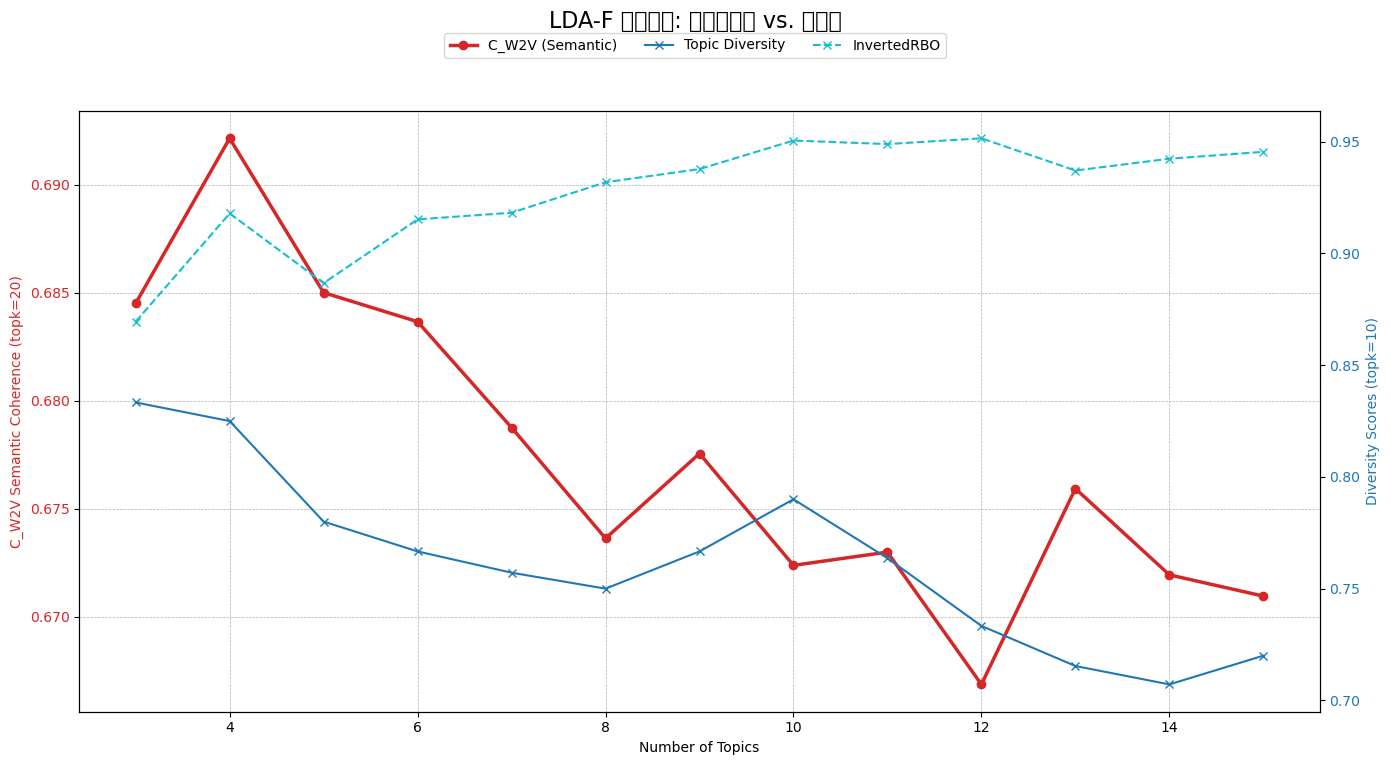

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import LdaMulticore, KeyedVectors
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO

PROCESSED_CORPUS_PICKLE = 'data/4-2/HDBSCAN/final_combined_documents.pkl' 
FINAL_DICTIONARY_PATH = 'data/4-2/HDBSCAN/final_dictionary.dict'
TENCENT_WV_PATH = 'data/origin/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt'
MODEL_SAVE_DIR = 'data/4-2/HDBSCAN/model/'
RESULTS_CSV_PATH = 'data/4-2/HDBSCAN/lda_f_evaluation.csv'

TOPIC_RANGE = range(3, 16)
def evaluate_models(model_dir, topic_range, processed_texts, dictionary, word_vectors):
    print("\n--- 开始进行模型评估 ---")
    results = []

    diversity_metric = TopicDiversity(topk=10)
    rbo_metric = InvertedRBO(topk=10, weight=0.9)

    for n_topics in topic_range:
        model_path = os.path.join(model_dir, f'lda_model_{n_topics}.model')
        if not os.path.exists(model_path):
            print(f"警告: 模型文件未找到，跳过: {model_path}")
            continue
            
        print(f"--- 正在评估: {n_topics} 主题的模型 ---")
        lda_model = LdaMulticore.load(model_path)

        topics_for_coherence = [[word for word, _ in lda_model.show_topic(i, topn=20)] for i in range(n_topics)]
        topics_for_diversity = [[word for word, _ in lda_model.show_topic(i, topn=10)] for i in range(n_topics)]

        coherence_model = CoherenceModel(
            topics=topics_for_coherence,
            texts=processed_texts,
            dictionary=dictionary,
            coherence='c_w2v',
            keyed_vectors=word_vectors
        )
        cw2v_semantic = coherence_model.get_coherence()

        model_output_for_diversity = {"topics": topics_for_diversity}
        diversity = diversity_metric.score(model_output_for_diversity)
        rbo = rbo_metric.score(model_output_for_diversity)

        print(f"  - C_W2V (Semantic, topk=20): {cw2v_semantic:.4f}")
        print(f"  - Topic Diversity (topk=10): {diversity:.4f}")
        print(f"  - InvertedRBO (topk=10): {rbo:.4f}")
        
        results.append({
            "num_topics": n_topics,
            "C_W2V (Semantic)": cw2v_semantic,
            "Topic Diversity": diversity,
            "InvertedRBO": rbo
        })
        
    return pd.DataFrame(results).set_index("num_topics")

def plot_results(results_df):
    print("\n--- 正在可视化评估结果... ---")
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('C_W2V Semantic Coherence (topk=20)', color='tab:red')
    ax1.plot(results_df.index, results_df['C_W2V (Semantic)'], color='tab:red', marker='o', linewidth=2.5, label='C_W2V (Semantic)')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Diversity Scores (topk=10)', color='tab:blue')
    ax2.plot(results_df.index, results_df['Topic Diversity'], color='tab:blue', marker='x', linestyle='-', label='Topic Diversity')
    ax2.plot(results_df.index, results_df['InvertedRBO'], color='tab:cyan', marker='x', linestyle='--', label='InvertedRBO')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.96), ncol=3, fontsize='medium')
    fig.suptitle('LDA-F 模型评估: 语义一致性 vs. 多样性', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

def main():
    print("--- 1. 正在加载评估所需的文件... ---")
    with open(PROCESSED_CORPUS_PICKLE, 'rb') as f:
        processed_texts = pickle.load(f)
    print(f" - 成功加载 {len(processed_texts)} 条原始文本。")

    dictionary = Dictionary.load(FINAL_DICTIONARY_PATH)
    print(f" - 成功加载最终词典 (大小: {len(dictionary)})。")

    print(" - 正在加载腾讯词向量模型...")
    word_vectors = KeyedVectors.load_word2vec_format(TENCENT_WV_PATH, binary=False)
    print(" - 成功加载腾讯词向量。")

    results_df = evaluate_models(MODEL_SAVE_DIR, TOPIC_RANGE, processed_texts, dictionary, word_vectors)
    
    if not results_df.empty:
        print("\n--- 评估完成, 最终结果如下: ---")
        print(results_df)

        os.makedirs(os.path.dirname(RESULTS_CSV_PATH), exist_ok=True)
        results_df.to_csv(RESULTS_CSV_PATH)
        print(f"\n评估结果已保存到 {RESULTS_CSV_PATH}")
        
        plot_results(results_df)
    else:
        print("\n--- 评估失败: 在指定目录下未找到任何模型文件 ---")

if __name__ == "__main__":
    main()

In [ ]:
#k-means

In [15]:
import pickle
import os
import time

INPUT_ORIGINAL_TEXT_PATH = 'data/paragraph.pkl'

INPUT_MERGED_CLUSTERS_PATH = 'data/4-2/k-means/KMEANS_on_reduced_vectors_pca_128d_norm\merged_documents.pkl'

OUTPUT_DIR = 'data/4-2/k-means/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_FINAL_DOCS_PATH = os.path.join(OUTPUT_DIR, 'final_combined_documents.pkl')


def recover_and_append_docs():
    print("=========================================================")
    print("--- 开始执行文档恢复与追加脚本 ---")
    print("=========================================================")
    start_time = time.time()

    print(f"\n--- 正在加载原始文档: {INPUT_ORIGINAL_TEXT_PATH} ---")
    if not os.path.exists(INPUT_ORIGINAL_TEXT_PATH):
        raise FileNotFoundError(f"原始文档文件未找到: {INPUT_ORIGINAL_TEXT_PATH}")
    with open(INPUT_ORIGINAL_TEXT_PATH, 'rb') as f:
        original_docs = pickle.load(f)
    print(f"成功加载 {len(original_docs)} 篇原始文档。")

    print(f"\n--- 正在加载已合并文档: {INPUT_MERGED_CLUSTERS_PATH} ---")
    if not os.path.exists(INPUT_MERGED_CLUSTERS_PATH):
        raise FileNotFoundError(f"已合并文档文件未找到: {INPUT_MERGED_CLUSTERS_PATH}")
    with open(INPUT_MERGED_CLUSTERS_PATH, 'rb') as f:
        merged_docs = pickle.load(f)
    print(f"成功加载 {len(merged_docs)} 篇已合并文档（包含簇和离群点）。")

    print("\n--- 正在进行去重和追加操作... ---")
    original_docs_as_tuples = {tuple(doc) for doc in original_docs}

    final_docs_list = list(original_docs)
    
    new_docs_added_count = 0
    for doc in merged_docs:
        if tuple(doc) not in original_docs_as_tuples:
            final_docs_list.append(doc)
            new_docs_added_count += 1
            
    print(f"操作完成！识别并添加了 {new_docs_added_count} 篇新的簇合并文档。")

    print("\n--- 最终结果统计 ---")
    print(f" - 原始文档数: {len(original_docs)}")
    print(f" - 新增的簇合并文档数: {new_docs_added_count}")
    print(f" - 最终总文档数: {len(final_docs_list)}")

    with open(OUTPUT_FINAL_DOCS_PATH, 'wb') as f:
        pickle.dump(final_docs_list, f)

    total_time = time.time() - start_time
    print(f"\n成功将最终的文档集保存到: {OUTPUT_FINAL_DOCS_PATH}")
    print(f"--- 整个过程耗时: {total_time:.2f} 秒 ---")
    print("=========================================================")


if __name__ == '__main__':
    recover_and_append_docs()

--- 开始执行文档恢复与追加脚本 ---

--- 正在加载原始文档: data/paragraph.pkl ---
成功加载 274378 篇原始文档。

--- 正在加载已合并文档: data/4-2/k-means/KMEANS_on_reduced_vectors_pca_128d_norm\merged_documents.pkl ---
成功加载 30000 篇已合并文档（包含簇和离群点）。

--- 正在进行去重和追加操作... ---
操作完成！识别并添加了 29311 篇新的簇合并文档。

--- 最终结果统计 ---
 - 原始文档数: 274378
 - 新增的簇合并文档数: 29311
 - 最终总文档数: 303689

成功将最终的文档集保存到: data/4-2/k-means/final_combined_documents.pkl
--- 整个过程耗时: 36.67 秒 ---


In [17]:
import pickle
import os  
from gensim.corpora import Dictionary
from collections import Counter

PROCESSED_CORPUS_PICKLE = 'data/4-2/k-means/final_combined_documents.pkl'
FILTERED_DICTIONARY_PATH = 'data/4-2/k-means/final_dictionary.dict'
FILTERED_CORPUS_PATH = 'data/4-2/k-means/final_corpus.pkl'

NO_BELOW = 10
NO_ABOVE = 0.35
KEEP_N = None


if __name__ == '__main__':
    print("--- 1. 加载预处理好的分词后文本 ---")
    with open(PROCESSED_CORPUS_PICKLE, 'rb') as f:
        processed_texts = pickle.load(f)
    print(f"成功加载 {len(processed_texts)} 条文本。")

    print("\n--- 2. 创建初始Gensim词典 (不过滤) ---")
    dictionary = Dictionary(processed_texts)
    initial_vocab_size = len(dictionary)
    print(f"初始词典大小: {initial_vocab_size}")

    print("\n--- 3. 分析将被各个过滤规则移除的词汇 ---")
    
    num_docs = dictionary.num_docs
    print(f"总文档数: {num_docs}")
    print("-" * 40)

    no_below_limit = NO_BELOW
    low_freq_ids = {tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq < no_below_limit}
    print(f"规则 'no_below = {NO_BELOW}' 分析:")
    print(f" - 文档频率低于 {no_below_limit} 的词汇有 {len(low_freq_ids)} 个。")

    no_above_limit = num_docs * NO_ABOVE
    high_freq_ids = {tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq > no_above_limit}
    print(f"\n规则 'no_above = {NO_ABOVE}' 分析:")
    print(f" - 文档频率高于 {NO_ABOVE:.0%} (即 > {int(no_above_limit)}个文档) 的词汇有 {len(high_freq_ids)} 个。")

    if high_freq_ids:
        print(" - 示例 (将被移除的高频词):")
        sorted_high_freq = sorted(high_freq_ids, key=lambda tokenid: dictionary.dfs[tokenid], reverse=True)
        for tokenid in sorted_high_freq[:5]:
            print(f"   - '{dictionary[tokenid]}' (在 {dictionary.dfs[tokenid]} 个文档中出现)")

    total_removed_ids = low_freq_ids.union(high_freq_ids)
    final_vocab_size_estimated = initial_vocab_size - len(total_removed_ids)

    print("\n--- 综合分析结果 ---")
    print(f"将被移除的低频词总数: {len(low_freq_ids)}")
    print(f"将被移除的高频词总数: {len(high_freq_ids)}")
    print(f"将被移除的独立词汇总数: {len(total_removed_ids)}")
    print("-" * 40)
    print(f"预计过滤后的词典大小: {final_vocab_size_estimated}")
    print("-" * 40)

    print("\n--- 4. 实际执行Gensim的 filter_extremes 操作 ---")
    dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE, keep_n=KEEP_N)
    dictionary.compactify()
    
    final_vocab_size_actual = len(dictionary)
    print(f"Gensim过滤后，实际最终词典大小: {final_vocab_size_actual}")

    if final_vocab_size_actual == final_vocab_size_estimated:
        print("验证成功：手动分析结果与Gensim执行结果一致。")
    else:
        print("警告：手动分析结果与Gensim执行结果不一致，请检查逻辑。")


    print("\n--- 5. 创建并保存最终的BoW语料库和词典 ---")

    output_dir = os.path.dirname(FILTERED_DICTIONARY_PATH)
    os.makedirs(output_dir, exist_ok=True)
    
    corpus = [dictionary.doc2bow(text) for text in processed_texts]
    
    dictionary.save(FILTERED_DICTIONARY_PATH)
    with open(FILTERED_CORPUS_PATH, 'wb') as f:
        pickle.dump(corpus, f)
        
    print(f"最终词典已保存至: {FILTERED_DICTIONARY_PATH}")
    print(f"最终BoW语料库已保存至: {FILTERED_CORPUS_PATH}")

--- 1. 加载预处理好的分词后文本 ---
成功加载 303689 条文本。

--- 2. 创建初始Gensim词典 (不过滤) ---
初始词典大小: 329810

--- 3. 分析将被各个过滤规则移除的词汇 ---
总文档数: 303689
----------------------------------------
规则 'no_below = 10' 分析:
 - 文档频率低于 10 的词汇有 229965 个。

规则 'no_above = 0.35' 分析:
 - 文档频率高于 35% (即 > 106291个文档) 的词汇有 1 个。
 - 示例 (将被移除的高频词):
   - '宁德时代' (在 156308 个文档中出现)

--- 综合分析结果 ---
将被移除的低频词总数: 229965
将被移除的高频词总数: 1
将被移除的独立词汇总数: 229966
----------------------------------------
预计过滤后的词典大小: 99844
----------------------------------------

--- 4. 实际执行Gensim的 filter_extremes 操作 ---
Gensim过滤后，实际最终词典大小: 99844
验证成功：手动分析结果与Gensim执行结果一致。

--- 5. 创建并保存最终的BoW语料库和词典 ---
最终词典已保存至: data/4-2/k-means/final_dictionary.dict
最终BoW语料库已保存至: data/4-2/k-means/final_corpus.pkl


In [1]:
import pickle
import os
import time
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import multiprocessing

FINAL_DICTIONARY_PATH = 'data/4-2/k-means/final_dictionary.dict'
FINAL_CORPUS_PATH = 'data/4-2/k-means/final_corpus.pkl'

MODEL_SAVE_DIR = 'data/4-2/k-means/model/'
TOPIC_RANGE = range(3, 16)

if __name__ == '__main__':
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    num_workers = multiprocessing.cpu_count() - 2 if multiprocessing.cpu_count() > 2 else 1
    print(f"--- 将为每个LDA模型训练使用 {num_workers} 个CPU核心 ---")

    print("\n--- 1. 正在加载经过词典过滤的最终语料库和词典... ---")
    if not os.path.exists(FINAL_DICTIONARY_PATH) or not os.path.exists(FINAL_CORPUS_PATH):
        raise FileNotFoundError("错误：找不到最终的词典或语料库文件。请先运行词典过滤脚本。")
        
    dictionary = Dictionary.load(FINAL_DICTIONARY_PATH)
    with open(FINAL_CORPUS_PATH, 'rb') as f:
        corpus = pickle.load(f)
    print(f"加载成功。词典大小: {len(dictionary)}，语料库文档数: {len(corpus)}")


    print("\n--- 2. 开始批量训练LDA模型 ---")
    start_time = time.time()
    
    for n_topics in TOPIC_RANGE:
        print(f"\n--- 开始训练: {n_topics} 主题 ---")

        model = LdaMulticore(
            corpus=corpus,          
            num_topics=n_topics,      
            id2word=dictionary,           
            random_state=42,           
            passes=10,                 
            workers=num_workers,       
        )
        
        model_path = os.path.join(MODEL_SAVE_DIR, f'lda_model_{n_topics}.model')
        model.save(model_path)
        print(f"--- 已保存: {n_topics} 主题的模型至 {model_path} ---")

    end_time = time.time()
    print(f"\n--- 全部模型训练完毕, 总耗时: {end_time - start_time:.2f} 秒 ---")
    print(f"所有模型已保存在: {MODEL_SAVE_DIR}")

--- 将为每个LDA模型训练使用 14 个CPU核心 ---

--- 1. 正在加载经过词典过滤的最终语料库和词典... ---
加载成功。词典大小: 99844，语料库文档数: 303689

--- 2. 开始批量训练LDA模型 ---

--- 开始训练: 3 主题 ---
--- 已保存: 3 主题的模型至 data/4-2/k-means/model/lda_model_3.model ---

--- 开始训练: 4 主题 ---
--- 已保存: 4 主题的模型至 data/4-2/k-means/model/lda_model_4.model ---

--- 开始训练: 5 主题 ---
--- 已保存: 5 主题的模型至 data/4-2/k-means/model/lda_model_5.model ---

--- 开始训练: 6 主题 ---
--- 已保存: 6 主题的模型至 data/4-2/k-means/model/lda_model_6.model ---

--- 开始训练: 7 主题 ---
--- 已保存: 7 主题的模型至 data/4-2/k-means/model/lda_model_7.model ---

--- 开始训练: 8 主题 ---
--- 已保存: 8 主题的模型至 data/4-2/k-means/model/lda_model_8.model ---

--- 开始训练: 9 主题 ---
--- 已保存: 9 主题的模型至 data/4-2/k-means/model/lda_model_9.model ---

--- 开始训练: 10 主题 ---
--- 已保存: 10 主题的模型至 data/4-2/k-means/model/lda_model_10.model ---

--- 开始训练: 11 主题 ---
--- 已保存: 11 主题的模型至 data/4-2/k-means/model/lda_model_11.model ---

--- 开始训练: 12 主题 ---
--- 已保存: 12 主题的模型至 data/4-2/k-means/model/lda_model_12.model ---

--- 开始训练: 13 主题 ---
--- 已保存: 13 主题的模型

--- 1. 正在加载评估所需的文件... ---
 - 成功加载 303689 条原始文本。
 - 成功加载最终词典 (大小: 99844)。
 - 正在加载腾讯词向量模型...
 - 成功加载腾讯词向量。

--- 开始进行模型评估 ---
--- 正在评估: 3 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6777
  - Topic Diversity (topk=10): 0.8667
  - InvertedRBO (topk=10): 0.9163
--- 正在评估: 4 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6866
  - Topic Diversity (topk=10): 0.8750
  - InvertedRBO (topk=10): 0.9288
--- 正在评估: 5 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6790
  - Topic Diversity (topk=10): 0.7800
  - InvertedRBO (topk=10): 0.9099
--- 正在评估: 6 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6770
  - Topic Diversity (topk=10): 0.7667
  - InvertedRBO (topk=10): 0.9066
--- 正在评估: 7 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6749
  - Topic Diversity (topk=10): 0.7429
  - InvertedRBO (topk=10): 0.9233
--- 正在评估: 8 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6767
  - Topic Diversity (topk=10): 0.7500
  - InvertedRBO (topk=10): 0.9347
--- 正在评估: 9 主题的模型 ---
  - C_W2V (Semantic, topk=20): 0.6787
  - Topic Diversity (topk

C:\Users\Zhao\AppData\Local\Temp\ipykernel_10536\1729112077.py:87: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_10536\1729112077.py:87: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_10536\1729112077.py:87: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_10536\1729112077.py:87: UserWarning: Glyph 20272 (\N{CJK UNIFIED IDEOGRAPH-4F30}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0.03, 1, 0.92])
C:\Users\Zhao\AppData\Local\Temp\ipykernel_10536\1729112077.py:87: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  fig.tight_layout(rect=[0, 0

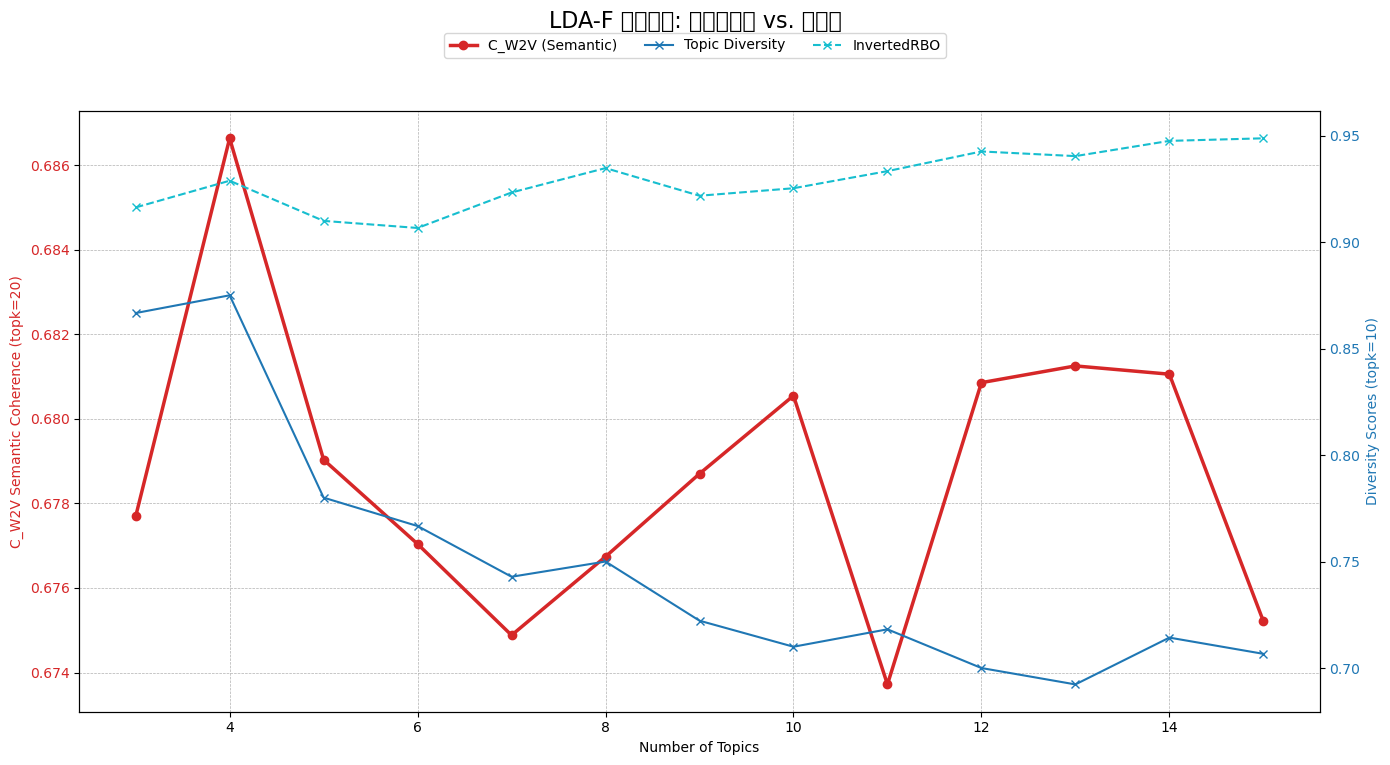

In [3]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import LdaMulticore, KeyedVectors
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO

PROCESSED_CORPUS_PICKLE = 'data/4-2/k-means/final_combined_documents.pkl' 

FINAL_DICTIONARY_PATH = 'data/4-2/k-means/final_dictionary.dict'

TENCENT_WV_PATH = 'data/origin/tencent-ailab-embedding-zh-d100-v0.2.0-s.txt'

MODEL_SAVE_DIR = 'data/4-2/k-means/model/'

RESULTS_CSV_PATH = 'data/4-2/k-means/lda_f_evaluation.csv'

TOPIC_RANGE = range(3, 16)

def evaluate_models(model_dir, topic_range, processed_texts, dictionary, word_vectors):
    print("\n--- 开始进行模型评估 ---")
    results = []

    diversity_metric = TopicDiversity(topk=10)
    rbo_metric = InvertedRBO(topk=10, weight=0.9)

    for n_topics in topic_range:
        model_path = os.path.join(model_dir, f'lda_model_{n_topics}.model')
        if not os.path.exists(model_path):
            print(f"警告: 模型文件未找到，跳过: {model_path}")
            continue
            
        print(f"--- 正在评估: {n_topics} 主题的模型 ---")
        lda_model = LdaMulticore.load(model_path)

        topics_for_coherence = [[word for word, _ in lda_model.show_topic(i, topn=20)] for i in range(n_topics)]
        topics_for_diversity = [[word for word, _ in lda_model.show_topic(i, topn=10)] for i in range(n_topics)]

        coherence_model = CoherenceModel(
            topics=topics_for_coherence,
            texts=processed_texts,
            dictionary=dictionary,
            coherence='c_w2v',
            keyed_vectors=word_vectors
        )
        cw2v_semantic = coherence_model.get_coherence()

        model_output_for_diversity = {"topics": topics_for_diversity}
        diversity = diversity_metric.score(model_output_for_diversity)
        rbo = rbo_metric.score(model_output_for_diversity)

        print(f"  - C_W2V (Semantic, topk=20): {cw2v_semantic:.4f}")
        print(f"  - Topic Diversity (topk=10): {diversity:.4f}")
        print(f"  - InvertedRBO (topk=10): {rbo:.4f}")
        
        results.append({
            "num_topics": n_topics,
            "C_W2V (Semantic)": cw2v_semantic,
            "Topic Diversity": diversity,
            "InvertedRBO": rbo
        })
        
    return pd.DataFrame(results).set_index("num_topics")

def plot_results(results_df):
    print("\n--- 正在可视化评估结果... ---")
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # 左Y轴: 语义一致性
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('C_W2V Semantic Coherence (topk=20)', color='tab:red')
    ax1.plot(results_df.index, results_df['C_W2V (Semantic)'], color='tab:red', marker='o', linewidth=2.5, label='C_W2V (Semantic)')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 右Y轴: 多样性指标
    ax2 = ax1.twinx()
    ax2.set_ylabel('Diversity Scores (topk=10)', color='tab:blue')
    ax2.plot(results_df.index, results_df['Topic Diversity'], color='tab:blue', marker='x', linestyle='-', label='Topic Diversity')
    ax2.plot(results_df.index, results_df['InvertedRBO'], color='tab:cyan', marker='x', linestyle='--', label='InvertedRBO')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.96), ncol=3, fontsize='medium')
    fig.suptitle('LDA-F 模型评估: 语义一致性 vs. 多样性', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

def main():
    print("--- 1. 正在加载评估所需的文件... ---")
    with open(PROCESSED_CORPUS_PICKLE, 'rb') as f:
        processed_texts = pickle.load(f)
    print(f" - 成功加载 {len(processed_texts)} 条原始文本。")

    dictionary = Dictionary.load(FINAL_DICTIONARY_PATH)
    print(f" - 成功加载最终词典 (大小: {len(dictionary)})。")

    print(" - 正在加载腾讯词向量模型...")
    word_vectors = KeyedVectors.load_word2vec_format(TENCENT_WV_PATH, binary=False)
    print(" - 成功加载腾讯词向量。")

    results_df = evaluate_models(MODEL_SAVE_DIR, TOPIC_RANGE, processed_texts, dictionary, word_vectors)
    
    if not results_df.empty:
        print("\n--- 评估完成, 最终结果如下: ---")
        print(results_df)

        os.makedirs(os.path.dirname(RESULTS_CSV_PATH), exist_ok=True)
        results_df.to_csv(RESULTS_CSV_PATH)
        print(f"\n评估结果已保存到 {RESULTS_CSV_PATH}")
        
        plot_results(results_df)
    else:
        print("\n--- 评估失败: 在指定目录下未找到任何模型文件 ---")

if __name__ == "__main__":
    main()